Labels of points on Pareto frontier:
['P10', 'P14', 'P17', 'P19']


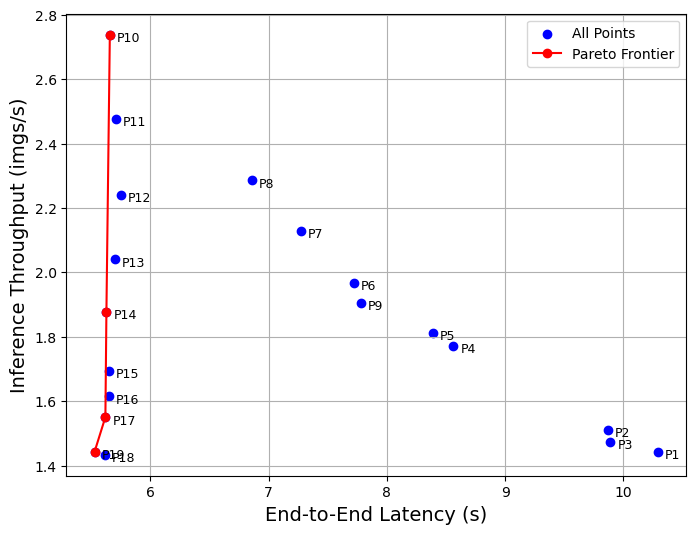

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# Path to the folder containing the metrics files
folder = 'mobilenetv2'  # Change this to your folder path

latencies = []
throughputs = []
labels = []

# Loop through all JSON files in the folder
for filename in os.listdir(folder):
    if filename.endswith('.json'):
        filepath = os.path.join(folder, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            # Extract the correct keys from the JSON structure
            throughput = data.get('system_inference_throughput_imgs_per_s')
            avg_metrics = data.get('average_metrics_per_batch', {})
            latency = avg_metrics.get('end_to_end_latency_s')
            if latency is not None and throughput is not None:
                latencies.append(latency)
                throughputs.append(throughput)
                # Extract split number from filename
                import re
                match = re.search(r'split_(\d+)', filename)
                if match:
                    label = f"P{match.group(1)}"
                else:
                    label = filename
                labels.append(label)

# Convert to numpy arrays for easier processing
latencies = np.array(latencies)
throughputs = np.array(throughputs)
labels = np.array(labels)

# Pareto frontier: minimize latency, maximize throughput
points = np.array(list(zip(latencies, throughputs)))
pareto_mask = np.ones(points.shape[0], dtype=bool)
for i, (lat, thr) in enumerate(points):
    # A point is not Pareto optimal if there exists another point with lower latency and higher throughput
    pareto_mask[i] = not np.any((latencies < lat) & (throughputs > thr))

pareto_points = points[pareto_mask]
pareto_labels = labels[pareto_mask]
pareto_points = pareto_points[np.argsort(pareto_points[:,0])]  # Sort by latency
pareto_labels = pareto_labels[np.argsort(pareto_points[:,0])]

print('Labels of points on Pareto frontier:')
print(list(pareto_labels))

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(latencies, throughputs, color='blue', label='All Points')
plt.plot(pareto_points[:,0], pareto_points[:,1], color='red', marker='o', linestyle='-', label='Pareto Frontier')

# Annotate each point with its label
for i, label in enumerate(labels):
    plt.annotate(label, (latencies[i], throughputs[i]), textcoords="offset points", xytext=(5,-5), ha='left', fontsize=9)

plt.xlabel('End-to-End Latency (s)', fontsize=14)
plt.ylabel('Inference Throughput (imgs/s)', fontsize=14)
#plt.title('Inference Throughput vs End-to-End Latency (MobileNetV2)')
plt.grid(True)
plt.legend()
plt.show()